In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, roc_auc_score 
from sklearn import svm, neighbors

from combat.pycombat import pycombat

In [50]:
STATUS_LIST =['relapse', 'no_relapse', 
              'test1relapse', 'test1no_relapse', 
              'test2relapse', 'test2no_relapse', 
              'NewTest1_Relapse', 'NewTest1_NoRelapse', 
              'NewTest2_Relapse', 'NewTest2_NoRelapse']

def status_map(status):
    if 'no_relapse' in status or 'NoRelapse' in status:
        return 0
    else:
        return 1

def batch_map(status):
        return STATUS_LIST.index(status)
    
    
class BcData:
    def __init__(self):
        self.data = pd.read_csv("data/data_good.csv")
        self.total = pd.read_csv("data/Total_old.csv", names=["gsm", "status"])
        self._drop_grey()
        self._log_table()
        self.data = self._groupby_gene()

    # Drop grey columns(gsm)
    def _drop_grey(self):
        self.gsm_series = self.total[self.total.status.isin(STATUS_LIST)].gsm
        new_cols = pd.Series(["GeneSymbol"]).append(self.gsm_series)

        self.total = self.total[self.total.gsm.isin(self.gsm_series)]
        self.data = self.data.filter(items=new_cols)

    # Group rows by gene leaving max median row
    def _groupby_gene(self):
        return self.data\
            .groupby("GeneSymbol", as_index=False, sort=False)\
            .apply(lambda f: f.loc[f.median(axis=1).idxmax()])

    def _log_table(self):
        index = self.data.iloc[:, 0]
        self.data = np.log2(self.data.iloc[:, 1:])
        self.data.insert(0, "GeneSymbol", index)

    def _get_status(self):
        return self.total.status.map(status_map)

    # Drop rows with quantile less than threshold (values = {7, 8, 9})
    def filter_percentile(self, quantile=1, threshold=9):
        q = self.data.quantile(q=quantile, axis=1)
        index = q[q >= threshold].index.values
        self.data = self.data.loc[index, :]

    # Drop rows with max/min diff less than threshold (values = {1.5, 2})
    def filter_diff_percentile(self, qmax=1, qmin=0, threshold=2):
        threshold = np.log2(threshold)
        max = self.data.quantile(q=qmax, axis=1)
        min = self.data.quantile(q=qmin, axis=1)
        index = max[max - min >= threshold].index.values
        self.data = self.data.loc[index, :]

    # batch effect
    def combat(self):
        batch = list(self.total.status.map(batch_map))
        self.data_corrected = pycombat(self.data.iloc[:, 1:], batch)        
        
    # transpose grouped data
    def get_data(self):
        grouped = self.data.T
        self.data = grouped.rename(columns=grouped.iloc[0]).drop(grouped.index[0])
        try:
            self.data_corrected = self.data_corrected.T
        except:
            print("No corrected data")
        
    # values = {0, 1, 2, 3, 4}
    def train_test_split(self, test_fold_number=0, corrected=False):
        test_status = STATUS_LIST[test_fold_number:test_fold_number+2]
        total_test = self.total[self.total.status.isin(test_status)]
        total_train = self.total[~self.total.status.isin(test_status)]
        
        if corrected:
            X_test = self.data_corrected.loc[total_test.gsm]
            X_train = self.data_corrected.loc[total_train.gsm]
        else:
            X_test = self.data.loc[total_test.gsm]
            X_train = self.data.loc[total_train.gsm]
            
        y_test = total_test.status.map(status_map)
        y_train = total_train.status.map(status_map)
        
        return X_train, X_test, y_train, y_test

In [51]:
bc = BcData()
bc.filter_diff_percentile(qmax=0.75, qmin=0.25, threshold=1.5)
bc.filter_percentile(quantile=0.75, threshold=7)
bc.data

,GeneSymbol,GSM441628,GSM441629,GSM441643,GSM441644,GSM441657,GSM441663,GSM441672,GSM441677,GSM441689,...,GSM79316,GSM79301,GSM79303,GSM79278,GSM79158,GSM79256,GSM79307,GSM79194,GSM79179,GSM79182
0,STAT1,10.118876,9.451877,8.354805,10.610259,10.741121,10.795358,10.542674,9.963624,9.622380,...,9.512118,9.142033,10.445532,8.601886,10.321116,8.950999,8.635794,8.230515,8.700245,9.350323
3,PRPF8,8.128170,9.802132,9.263711,8.182230,8.693173,8.526859,9.587142,8.660406,8.918318,...,9.266135,9.311937,8.627198,8.643070,9.391888,9.204001,8.580696,9.419642,8.443959,9.562798
14,RPL21,12.635421,11.963962,12.000292,12.462349,12.643096,12.370061,12.233763,12.567462,12.668776,...,12.010609,10.846705,11.189120,12.102232,12.309434,12.245642,11.965975,11.443871,12.144620,12.420044
25,EIF3F,10.289270,10.072535,10.945393,10.092387,10.580513,10.875888,10.830040,9.970379,11.165183,...,10.121326,9.888256,9.577146,9.874938,10.360507,10.311975,10.092823,9.829759,10.220415,10.725477
26,RPS5,12.364299,11.680135,12.400477,12.832138,12.345247,12.313745,12.400477,12.739049,12.569388,...,11.293679,11.065409,9.773309,10.869409,11.509409,11.912523,11.523003,11.217752,11.194246,11.948590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10477,LRRC59,9.541288,10.962997,9.558757,9.329373,9.670444,9.508076,11.591111,10.485105,9.490450,...,9.323670,9.107693,9.469125,7.690745,8.943681,8.402151,8.740300,8.911212,8.908648,8.306053
10482,ISYNA1,7.415488,7.001160,8.223167,7.161726,6.747656,7.640549,8.030700,6.885050,8.106401,...,7.091065,6.512758,7.020502,7.552646,7.408381,7.087123,7.902261,7.549222,7.005355,6.948893
10486,UBQLN4,6.924872,7.446132,7.195594,6.676366,6.585173,6.929081,6.122314,6.352729,7.348303,...,6.373460,6.827781,6.570428,7.501758,6.514496,7.016095,7.107803,6.418590,7.236885,7.152772
10488,SH3BP4,9.617671,7.911392,9.033233,8.471903,10.106589,9.130849,9.723787,10.184045,9.268830,...,9.387681,9.357279,9.122013,9.274756,8.862613,9.457364,9.034381,9.144337,10.007966,8.687159


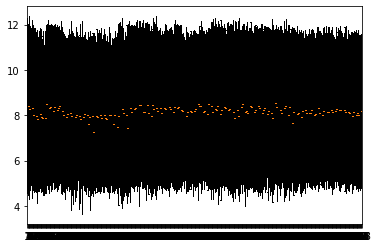

In [39]:
plt.boxplot(bc.data.iloc[:, 1:].T, 0, "")
plt.show()

Found 10 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


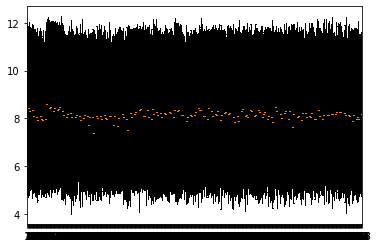

In [52]:
bc.combat()
plt.boxplot(bc.data_corrected.T, 0, "")
plt.show()

In [55]:
bc.data_corrected

,0,3,14,25,26,38,40,41,43,54,...,10468,10469,10470,10471,10476,10477,10482,10486,10488,10506
GSM441628,10.140551,8.370355,12.536094,10.385006,12.147300,11.945396,12.909184,10.074409,10.170205,8.837641,...,7.539414,10.386112,9.036098,8.017061,10.038118,9.278224,7.436820,6.906417,9.658149,5.289580
GSM441629,9.501611,9.825566,11.901063,10.212788,11.554241,11.536609,12.339300,9.681085,10.547129,9.094713,...,7.447583,10.538555,8.717952,7.495819,9.272392,10.384080,7.028139,7.363409,8.131853,8.542037
GSM441643,8.450693,9.357505,11.935423,10.906363,12.178661,11.397592,12.537267,9.420280,10.722118,8.483727,...,6.152376,10.832162,9.159297,7.456272,9.618609,9.291812,8.233489,7.143761,9.135359,8.034393
GSM441644,10.611261,8.417351,12.372412,10.228563,12.552842,11.854641,12.767835,9.615537,10.217197,8.831796,...,7.673314,9.967120,9.008723,6.034794,10.053786,9.113388,7.186517,6.688551,8.633239,5.896973
GSM441657,10.736619,8.861524,12.543353,10.616428,12.130786,12.183941,12.803158,9.714435,10.367298,9.655065,...,8.732044,10.979999,8.504404,6.379825,9.728129,9.378686,6.778090,6.608601,10.095494,7.140349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM79256,9.019267,8.917505,12.608758,10.444084,12.337379,12.272700,12.971019,9.245559,10.669304,8.786230,...,6.381902,10.216995,7.732136,6.863658,9.442218,8.372183,7.048837,7.426593,9.333607,5.620310
GSM79307,8.682615,8.098371,12.317241,10.147071,11.872594,12.200119,12.799797,9.389615,11.030892,8.340260,...,7.453717,10.065914,7.812972,7.319174,9.394063,8.774101,7.949063,7.540706,8.838441,6.349537
GSM79194,8.249760,9.200895,11.773011,9.790544,11.508360,10.971431,12.269038,9.269431,9.826563,7.651672,...,5.696910,10.190085,7.558321,7.506228,8.519305,8.977243,7.559173,6.683112,8.967161,7.290228
GSM79179,8.751452,7.918675,12.503456,10.319993,11.480312,12.377559,12.343357,8.924331,10.202133,9.109854,...,6.473988,10.534363,8.526323,7.528177,9.562594,8.974195,6.958534,7.701323,9.978169,7.437142


In [54]:
X_train, X_test, y_train, y_test = bc.train_test_split(test_fold_number=0)

# weights = {"uniform", "distance"}
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
score = clf.score(X_test, y_test)

print("Initial data sensitivity = {} auc = {} score = {}".format(recall, auc, score))

X_train, X_test, y_train, y_test = bc.train_test_split(test_fold_number=0, corrected=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
score = clf.score(X_test, y_test)

print("Corrected data sensitivity = {} auc = {} score = {}".format(recall, auc, score))

Initial data sensitivity = 0.40476190476190477 auc = 0.6520664869721473 score = 0.7960199004975125
Corrected data sensitivity = 0.38095238095238093 auc = 0.6370170709793351 score = 0.7860696517412935


$$ \texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i) $$
$$
recall(sensitivity) = \frac{tp}{tp + fn}
$$

In [10]:
X_train, X_test, y_train, y_test = bc.train_test_split(test_fold_number=2)

# Set dual = True if number of features > number of examples and vice versa
# clf = svm.LinearSVC(penalty='l1', dual=False, C=1, max_iter=100000)
clf  = svm.SVC(kernel="linear", C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("sensitivity = {} auc = {}".format(recall, auc))

sensitivity = 0.5833333333333334 auc = 0.6871890547263683


In [22]:
step = 50
total = len(X_train.columns)

# for i in range(0, total, step):
for i in range(total):
    if i + step >= total:
        break
        
    clf  = svm.SVC(kernel="linear", C=1)
    clf.fit(X_train.iloc[:, i:i+step], y_train)

    y_pred = clf.predict(X_test.iloc[:, i:i+step])
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    if (recall > 0.6 and auc > 0.65):
        print("For {} step: sensitivity = {} auc = {}".format(i, recall, auc))    

For 8 step: sensitivity = 0.6666666666666666 auc = 0.7213930348258706
For 9 step: sensitivity = 0.6666666666666666 auc = 0.7288557213930348
For 15 step: sensitivity = 0.75 auc = 0.7854477611940298
For 16 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 17 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 18 step: sensitivity = 0.75 auc = 0.7779850746268656
For 19 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 20 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 21 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 22 step: sensitivity = 0.6666666666666666 auc = 0.736318407960199
For 32 step: sensitivity = 0.6666666666666666 auc = 0.7587064676616915
For 160 step: sensitivity = 0.6666666666666666 auc = 0.7288557213930348
For 193 step: sensitivity = 0.6666666666666666 auc = 0.7288557213930348
For 194 step: sensitivity = 0.6666666666666666 auc = 0.7064676616915422
For 195 step: sensitivity = 0.6666

For 2129 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 2130 step: sensitivity = 0.6666666666666666 auc = 0.6990049751243781
For 2131 step: sensitivity = 0.6666666666666666 auc = 0.7213930348258706
For 2132 step: sensitivity = 0.6666666666666666 auc = 0.7512437810945273
For 2133 step: sensitivity = 0.6666666666666666 auc = 0.7512437810945273
For 2186 step: sensitivity = 0.6666666666666666 auc = 0.7661691542288557
For 2199 step: sensitivity = 0.6666666666666666 auc = 0.7437810945273631
For 2201 step: sensitivity = 0.75 auc = 0.8078358208955224
For 2206 step: sensitivity = 0.6666666666666666 auc = 0.7661691542288557
For 2348 step: sensitivity = 0.6666666666666666 auc = 0.7064676616915422
For 2349 step: sensitivity = 0.6666666666666666 auc = 0.7213930348258706
For 2368 step: sensitivity = 0.6666666666666666 auc = 0.7139303482587064
For 2698 step: sensitivity = 0.75 auc = 0.7555970149253731
For 2699 step: sensitivity = 0.6666666666666666 auc = 0.7139303482587064
For 28